In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2. Test the Foward part of the Network
> * Now make sure that we can map from an image into an SxSx2x11 Tensor
> * First make sure that the Yolo2 weights are loadable and make sense.

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
from Model.vis_utils import visualize_grid

In [10]:
# l2 = np.array(list((yolo_weights['model_weights']['conv2d_1']['conv2d_1'][u'kernel:0'])))
# grid = visualize_grid(l2.transpose(3, 1, 2, 0))
# print (grid.shape, l2.shape)
# plt.imshow(grid.astype('uint8'))
# plt.axis('off')
# plt.gcf().set_size_inches(5, 5)
# plt.show()

#### 2.1 Overfit Localizer in Tiny Data
> * For debugging, we run the foward, and backward pass for `a few`
epochs.

In [11]:
import torch
print(torch.__version__)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from Model.dataloader import NutritionDataset
from Model.net import LocalizerNet
from train import train_localizer, calculate_iou

0.4.0


In [12]:
def train_localizer_network():
    IMAGE_DIR = '../Data/FullData/RawImages/'
    BOXES = '../Data/FullData/BoundingBoxes.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    YOLO_PATH = '../Data/FullData/yolo.h5'
    debug=torch.cuda.is_available()
    dataset = DataLoader(
        NutritionDataset(IMAGE_DIR, BOXES, DATA_PATH, debug=debug),
        batch_size=32, shuffle=True, num_workers=4,
    )
    dev = DataLoader(
        NutritionDataset(IMAGE_DIR, BOXES, DATA_PATH, split='dev', debug=debug),
        batch_size=32, shuffle=True, num_workers=4,
    )
    model = LocalizerNet(YOLO_PATH)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4
    )
    r = train_localizer(model, optimizer, dataset, dev, epochs=500)
    return r    

In [13]:
train_losses, dev_losses, train_map, dev_map = train_localizer_network()

=== Performance Check ===
	 Train Loss =  0.06379513442516327
	 Dev Loss =  0.11182402074337006
	 Train mAP =  [0.1 0.  0.  0. ]
	 Dev mAP =  [0. 0. 0. 0.]
=== Performance Check ===
	 Train Loss =  0.04986695572733879
	 Dev Loss =  0.10006064921617508
	 Train mAP =  [0.16666667 0.         0.         0.        ]
	 Dev mAP =  [0. 0. 0. 0.]
=== Performance Check ===
	 Train Loss =  0.04462220519781113
	 Dev Loss =  0.09563605487346649
	 Train mAP =  [0.2 0.  0.  0. ]
	 Dev mAP =  [0. 0. 0. 0.]
=== Performance Check ===
	 Train Loss =  0.03915311023592949
	 Dev Loss =  0.09281225502490997
	 Train mAP =  [0.1 0.  0.  0. ]
	 Dev mAP =  [0. 0. 0. 0.]
=== Performance Check ===
	 Train Loss =  0.036535654217004776
	 Dev Loss =  0.08743780851364136
	 Train mAP =  [0.3 0.1 0.1 0.1]
	 Dev mAP =  [0. 0. 0. 0.]
=== Performance Check ===
	 Train Loss =  0.0323568619787693
	 Dev Loss =  0.07657784968614578
	 Train mAP =  [0.1 0.1 0.  0. ]
	 Dev mAP =  [0. 0. 0. 0.]
=== Performance Check ===
	 Train Lo

In [10]:
def plot(train, dev, title):
    plt.title(title)
    plt.plot(train, label='train'); plt.plot(dev, label='dev')
    plt.xlabel('Iteration')
    plt.show()

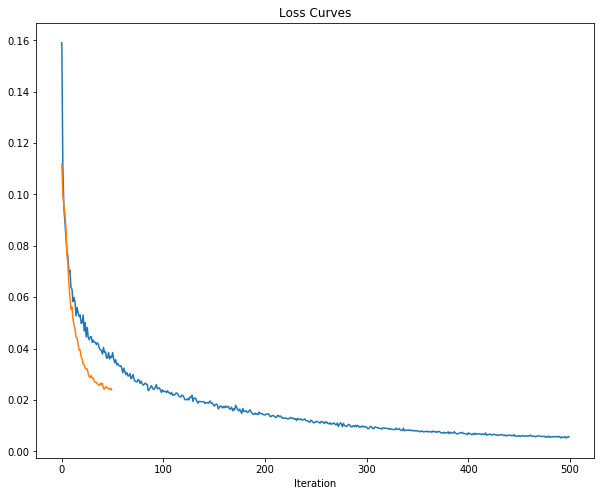

In [16]:
plot(train_losses, dev_losses, title='Loss Curves')